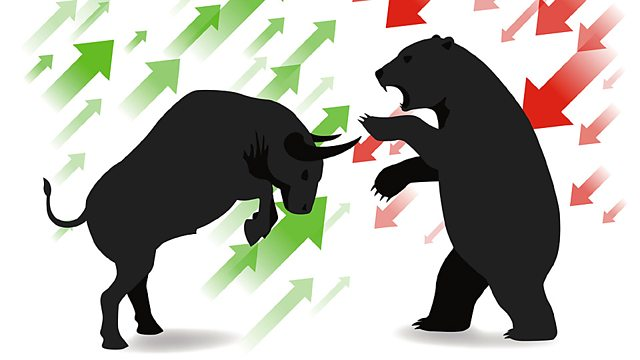
# NEWS Sentiment Analysis & its effects on Stock Market 
-- Aditi Bansal

# Introduction:
In this project I have collected news articles about Tesla Motors Inc., an American Automotive and Energy company (listed in S&P 500) from Dec 2017-Dec 2018, and using NLTK library performed sentiment analysis on them.The articles are collected using The New York Times API. Then I have correlated the news sentiment to the company's stock performace around the time the news was published. 

The project can be run on any other company aswell, by specifying the company's name in Article Search (company= 'Tesla') and setting company ticker (Ticker=Tesla) in Stock data collection. I have tried this with Apple. 

The project gives an overview of using APIs to scrape news articles, clean data and perform exploratory data analysis on the information extracted from the articles. Then using Natural Language Tool kit built-in sentiment analysis news-article sentiment is calculated. I used Wordclouds to show frequently occuring words in positive and negative news. Using yahoo-finance API stock data is collected and exploratory data analysis performed on stock data-  plot moving average, perform some trading analysis, candlestick stock plot using plotly, then correlate news around stock peaks and troughs. Finally using Pearsons correlation coefficient I have correlated news article sentiment and change in price in next days stock price and summarized the results.

The project is a learning experience to delve deeper into the huge areas of News collection, Sentiment Analysis, and Stock Market Analysis. During classes lectures about sentiment analysis were of interest to me and through this project I wish to learnt using APIs, NLTK , wordcloud and Stock trading strategies. 

# Tools used:

The following python library packages are required and used for this project. Here are links to documentation for them:
We are using Python 3 Jupyter Notebook for this project
https://docs.python.org/3/library/index.html: The Python 3 Standard Library contains most modules/packages used,
http://docs.python-requests.org/en/master/,
https://pandas.pydata.org/pandas-docs/stable/,
https://plot.ly/python/,
https://www.nltk.org/,
https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html,
https://docs.scipy.org/doc/,

In [117]:
#Libraries
import requests
import json
import pandas as pd
import time
from collections import Counter
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
from pandas_datareader import data
import plotly.offline as py_offline
import plotly.graph_objs as go
from scipy import stats
import numpy as np

# Part1: Scraping News headlines for an organization

Most news media have created Application Programming Interfaces (APIs) to enable computer applications to request stories and information about them. Most of these APIs are not free or their free versions have limitations like article-search capability for the last month. Some don't provide article search or filtering them using keywords, only provide top-headlines (eg. reddit PRAW).

For this project we demonstrate how to use the New York Times Article Search API (http://developer.nytimes.com/). This is a free API and with this one can search New York Times articles from Sept. 18, 1851 to today, retrieving headlines, abstracts, lead paragraphs, links to associated multimedia and other article metadata.  The API also returns interesting metadata like subject terms , persons and organizations (entities) in the news article as keywords.

To begin with one has to register on http://developer.nytimes.com/ for an API key. Then try the article-search console here(http://developer.nytimes.com/article_search_v2.json) which returns json output. Refer to this documentation(http://developer.nytimes.com/article_search_v2.json#/README) for creating url for article search and for using various the filtering options and parameters available and understanding output structure or response. We used some filtering options. We didnt use python wrappers like  nytimesarticle package, as they used to work 2 years ago but have bugs (filtering options dont work) now. 

The API has a limit of one call per second, hence we added one second delay in our code between consecutive calls, 1000 calls per day. Each search returns a json output of 10 results. We are analysing for last years articles which are rougly 150 articles. We search for company name in content and headline, limit source to New York Times (to avoid duplication), and sort by oldest first. We save the json data into pandas dataframe and into csv file (to reproduce analysis incase API is down)

Note- "hits" in response returned can be used to calculate no. of pages to traverse.

In [118]:
#Scrape news articles with content and headline containing Company Name Tesla and from 2017-12-01 - 2018-12-01
#To scrape article for another company set company name here
company = "Tesla"
begin_date = 20171201
end_date = 20181201

#Define blank dataframe
df = pd.DataFrame([])

#Iterate from page 0-15, each page gives 10 results. 
for page in range(0,15):
    url ="http://api.nytimes.com/svc/search/v2/articlesearch.json?q={}&page={}&fq=source:(%22The%20New%20York%20Times%22)AND%20headline:({})&begin_date={}&end_date={}&sort=oldest&api-key=78babcfadfbe468da2a609d2795c98cc".format(company, page, company, begin_date, end_date);
    #print(url)
    r = requests.get(url)
    #print(r.json()['response']['docs'])
    
    #save json in pandas dataframe
    df=df.append(pd.DataFrame.from_dict(r.json()['response']['docs']), sort=False)
    
    #Add 1s delay
    time.sleep(1)
        
df=df.reset_index()
df.to_csv(company+'_news.txt', header=True)
df.head(1)

index                       _id blog  \
0  0      5a478ded7c459f246b63d47b  {}    

                                                                                                                                                                                                                    byline  \
0  {'original': 'By JOHN F. WASIK', 'person': [{'firstname': 'John', 'middlename': 'F.', 'lastname': 'WASIK', 'qualifier': None, 'title': None, 'role': 'reported', 'organization': '', 'rank': 1}], 'organization': None}   

  document_type  \
0  article        

                                                                                                                                                                                                                       headline  \
0  {'main': 'Tesla the Car Is a Household Name. Long Ago, So Was Nikola Tesla.', 'kicker': None, 'content_kicker': None, 'print_headline': 'His Name Is a Household Word. Who Was He?', 'name': None, 'seo': None, 'sub': None}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     keywords  \
0  [{'name': 'persons', 'value': 'Tesla, Nikola', 'rank': 1, 'major': 'N'}, {'name': 'subject', 'value': 'Radio', 'rank': 2, 'major': 'N'}, {'name': 'subject', 'value': 'Robots and Robotics', 'rank': 3, 'major': 'N'}, {'name': 'subject', 'value': 'Drones (Pilotless Planes)', 'rank': 4, 'major': 'N'}, {'name': 'subject', 'value': 'Remote Control Systems', 'rank': 5, 'major': 'N'}, {'name': 'subject', 'value': 'Electric Light and Power', 'rank': 6, 'major': 'N'}, {'name': 'subject', 'value': 'Inventions and Patents', 'rank': 7, 'major': 'N'}, {'name': 'persons', 'value': 'Edison, Thomas A', 'rank': 8, 'major': 'N'}]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

# Part1.1: Data Cleaning of News articles

The company csv file data is read into pandas dataframe. The columns blog, byline, document_type, multimedia, print_page, uri which are constant for not useful for analysis are dropped. News publication date is converted to pandas datetime object. The headline is a string type dictionary and contains main headline, kicker etc information. The main headline is extracted from headline and cleaned dataframe is shown

                "headline": {
                    "main": "Virginia Attorney General Backs Off Ballot Proposal",
                    "kicker": "The Caucus"
                },



In [119]:
#Read news articles from csv to pandas dataframe
df= pd.read_csv(company+'_news.txt')
df.head()

#Data cleaning 
#Removing columns blog, byline, document_type, multimedia, print_page, uri which are constant for not useful for analysis 
#print(df.columns)
df = df.drop(['Unnamed: 0', 'index', 'blog', 'byline', 'document_type', 'multimedia', 'print_page', 'uri', 'section_name'], axis=1)

#Convert publication date to datetime object
df['pub_date'] = pd.to_datetime(df['pub_date'])

#Extract main headline from headline column
#column value is str type, change to dict using eval
df['headline']= df['headline'].apply(eval).apply(lambda x: x['main'])

df.head()

_id  \
0  5a478ded7c459f246b63d47b   
1  5a4b97157c459f246b63d85a   
2  5a4e75d27c459f29e79b20fe   
3  5a4e76fd7c459f29e79b22e3   
4  5a57cd2f7c459f29e79b381a   

                                                                   headline  \
0  Tesla the Car Is a Household Name. Long Ago, So Was Nikola Tesla.          
1  What’s on TV Tuesday: ‘Tesla’s Death Ray’ and Near East Relief             
2  Tesla Pushes Back Its Model 3 Targets Again: DealBook Briefing             
3  Tesla Reports New Setback for Model 3, With Output Lagging                 
4  Electric Vehicle Tax Credit Survives, but G.M. and Tesla Aren’t Cheering   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     keywords  \
0  [{'name': 'persons', 'value': 'Tesla, Nikola', 'rank': 1, 'major': 'N'}, {'name': 'subject', 'value': 'Radio', 'rank': 2, 'major': 'N'}, {'name': 'subject', 'value': 'Robots and Robotics', 'rank': 3, 'major': 'N'}, {'name': 'subject', 'value': 'Drones (Pilotless Planes)', 'rank': 4, 'major': 'N'}, {'name': 'subject', 'value': 'Remote Control Systems', 'rank': 5, 'major': 'N'}, {'name': 'subject', 'value': 'Electric Light and Power', 'rank': 6, 'major': 'N'}, {'name': 'subject', 'value': 'Inventions and Patents', 'rank': 7, 'major': 'N'}, {'name': 'persons', 'value': 'Edison, Thomas A', 'rank': 8, 'major': 'N'}]   
1  [{'name': 'subject', 'value': 'Television', 'rank': 1, 'major': 'N'}, {'name': 'subject', 'value': 'Movies', 'rank': 2, 'major': 'N'}, {'name': 'subject', 'value': 'Documentary Films and Programs', 'rank': 3, 'major': 'N'}]                                                                                                                                                                                                                                                                                                                                                                                                              
2  [{'name': 'subject', 'value': 'Mergers, Acquisitions and Divestitures', 'rank': 1, 'major': 'N'}, {'name': 'organizations', 'value': 'Ant Financial Services Group', 'rank': 2, 'major': 'N'}, {'name': 'organizations', 'value': 'MoneyGram International Inc', 'rank': 3, 'major': 'N'}, {'name': 'glocations', 'value': 'China', 'rank': 4, 'major': 'N'}]                                                                                                                                                                                                                                                                                
3  [{'name': 'subject', 'value': 'Automobiles', 'rank': 1, 'major': 'N'}, {'name': 'organizations', 'value': 'Tesla Motors Inc', 'rank': 2, 'major': 'N'}, {'name': 'persons', 'value': 'Musk, Elon', 'rank': 3, 'major': 'N'}, {'name': 'subject', 'value': 'Factories and Manufacturing', 'rank': 4, 'major': 'N'}]                                                                                                                                                                                                                                                                                                                           
4  [{'name': 'subject', 'value': 'Electric and Hybrid Vehicles', 'rank': 1, 'major': 'N'}, {'name': 'subject', 'value': 'Tax Credits, Deductions and Exemptions', 'rank': 2, 'major': 'N'}, {'name': 'subject', 'value': 'United States Polit

# Part 1.2: EDA of News articles 

The keywords column contains interesting subject items, and entities like persons, organization, glocations in the article content. It is a list of dictionary in string format. We extract the subjects from all articles in all_subjects. Using Counter package frequency of most common subjects is calculated and Top 10 subjects are listed.  

Here is how keywords response output look--

[{
                        "rank": "1",
                        "name": "type_of_material",
                        "value": "News"
                    },
                    {
                        "rank": "6",
                        "name": "persons",
                        "value": "Romney, Mitt"
                    },
                    {
                        "rank": "7",
                        "name": "subject",
                        "value": "Presidential Election of 2012"
                    },
                    {
                        "rank": "8",
                        "name": "organizations",
                        "value": "Republican Party"
                    },
                    {
                        "rank": "9",
                        "name": "glocations",
                        "value": "Virginia"
                    }]


Tesla is renowned for its Electric and Hybrid Vehicles, is an Automobile firm and major forerunner in designing driverless and semiautonomous cars, hence these results meet our expectations for articles about Tesla. 

In [120]:
# Extracting subjects about which the articles talks about, after parsing keywords column
all_subjects=[]

for idx,i in df.iterrows():
        # subject
        subjects = []
        # convert str to list 
        i['keywords']= ast.literal_eval(i['keywords'])
        
        #Iterate over list of dictionaries- Similarly names of persons, organizations, glocations can be extracted
        for x in range(0,len(i['keywords'])):
            if 'subject' in i['keywords'][x]['name']:
                subjects.append(i['keywords'][x]['value'])
                all_subjects.append(i['keywords'][x]['value'])
                
        #print(subjects, idx)
        df.loc[idx,'subject'] = str(subjects)

#Frequency of most common subjects 
counts = Counter(all_subjects)
print(" Top 10 Subjects in the NEWS Articles:\n",counts.most_common(10))


 Top 10 Subjects in the NEWS Articles:
 [('Electric and Hybrid Vehicles', 51), ('Stocks and Bonds', 26), ('Automobiles', 24), ('Securities and Commodities Violations', 16), ('Factories and Manufacturing', 14), ('Company Reports', 9), ('Boards of Directors', 9), ('Appointments and Executive Changes', 8), ('Driverless and Semiautonomous Vehicles', 8), ('Traffic Accidents and Safety', 6)]


The subject frequency histogram is plotted. The text is rotated on x axis to avoid overlap, figuresize is also selected to avoid overlap. This gives all the subjects and counts in a glance.

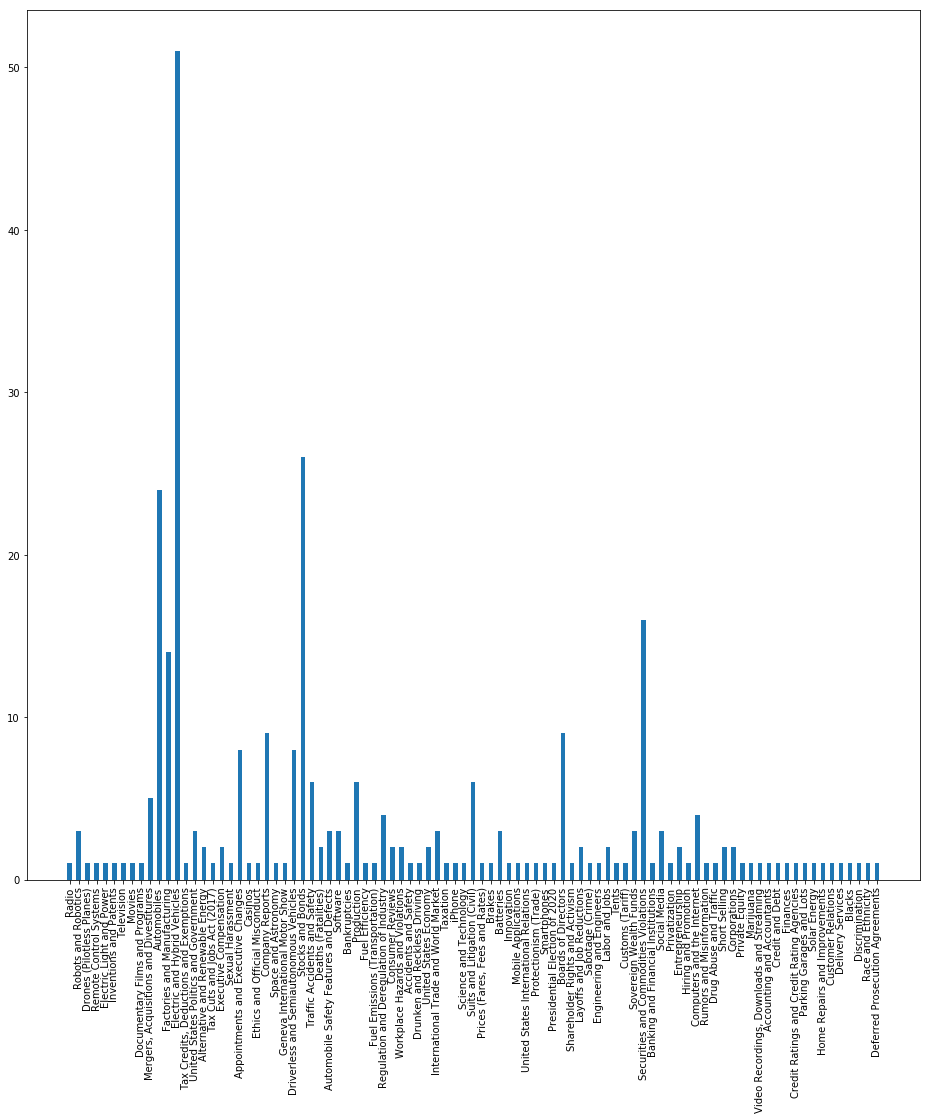

In [121]:
pd.set_option('display.max_colwidth', -1)

#To avoid text overlap rotate xticks and specify figure size. Plotting bar histogram of counts.
plt.figure(figsize=(16,16))
ax = plt.axes()
ax.set_xticklabels(counts.keys(), rotation=90)

plt.bar(counts.keys(), counts.values(), width=.5)
plt.show()

The news articles about Tesla were collected for year of 2018. Total articles collected is 101. Here no.of articles vs day of year is plotted - it gives which days articles were gathered as some days no. of articles were more. In August-September time there were more no. of articles per day (~7)

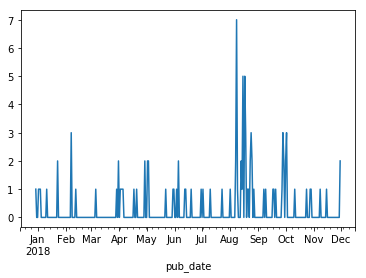

In [122]:
#no. of articles published each day of year 2018
df.resample('D', on='pub_date').size().plot(kind='line')

No. of articles gathered per month is calculated and displayed. In month of August max number of articles were gathered.

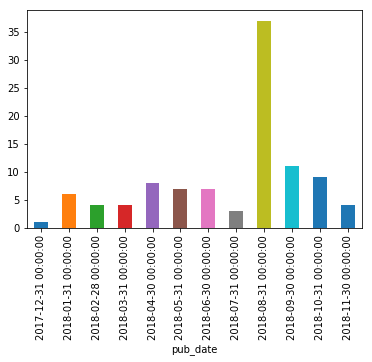

In [123]:
#No. of articles published each month
df.resample('M', on='pub_date').size().plot(kind='bar')

Plotting the various types of news categories (using news_desk) as a pie chart. The percentage is displayed in the chart. 

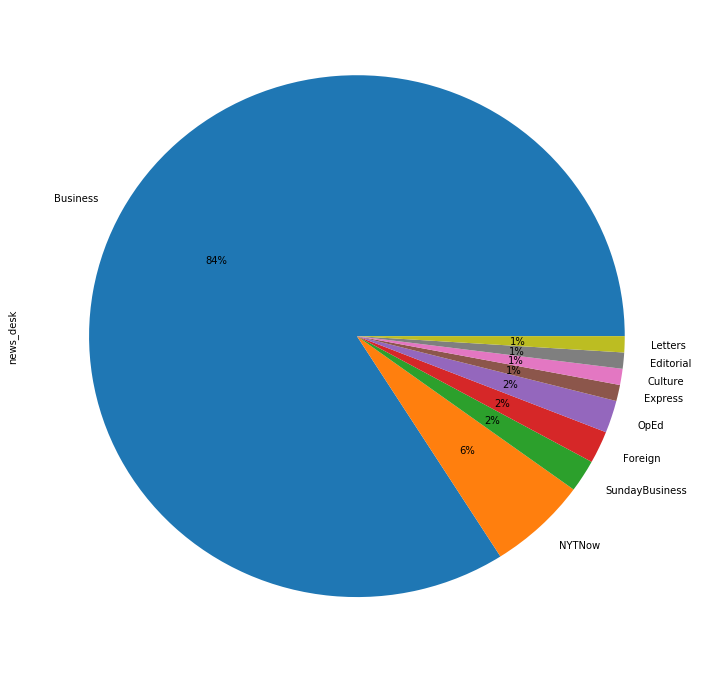

In [124]:
#plot pie chart of types of news_desk in a 12inch*12inch figure to avoid text overlap
#plot percentage inside chart
plt.figure(figsize=(12,12))
df['news_desk'].value_counts().plot(kind='pie', autopct='%1.0f%%')


Here we first list how many articles have identified organization as Tesla Motors Inc. 85/101 articles have. Some articles just talks about Nikola Tesla and not related to Tesla Inc.

While searching for articles, source was specified as The New York Times. A simple sanity check is value_counts on source returns one source: The New York Times

In [125]:
#How many articles have keyword organization: Tesla Motors Inc
print(len(df[df['keywords'].str.contains("{'name': 'organizations', 'value': 'Tesla Motors Inc'")]), "Articles out of",len(df),"have keyword Organization: Tesla Motors Inc.")

#Sanity check, when searching for news articles we searched for articles with source:The New York Times.
#Hence value_counts should return only entry
print(df.source.value_counts())

85 Articles out of 101 have keyword Organization: Tesla Motors Inc.
The New York Times    101
Name: source, dtype: int64


# Part2: News Sentiment Analysis

For sentiment analysis Natural Language Toolkit (NLTK) python package is used. To see how to install NLTK, you can go here: http://www.nltk.org/install.html. You'll need to open Python command line and run nltk.download() to grab NLTK's databases for eg, Vader lexicon database. 

We have used NLTK’s built-in Vader Sentiment Analyzer to rank a news summary or snippet as positive, negative or neutral using a lexicon of positive and negative words. We can utilize this tool by first creating a Sentiment Intensity Analyzer (SIA) to categorize our headlines, then we'll use the polarity_scores method to get the sentiment. We'll append each sentiment dictionary to a results list, which we'll transform into a dataframe.

Refer to https://github.com/cjhutto/vaderSentiment for details about Vader Sentiment tool.

In [126]:
#News Sentiment Analysis using Natural Language Toolkit (NLTK) python package.
#Using NLTK’s built-in Vader Sentiment Analyzer to rank polarity of news snippets as positive, negative & neutral.
#nltk.download() function used to download vader lexicon file
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for line in df.snippet:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

df1 = pd.DataFrame.from_records(results)
df1['date']= df['pub_date']
df1.head()

compound  \
0  0.3818     
1 -0.7430     
2  0.0000     
3  0.0000     
4 -0.6346     

                                                                                                                                                         headline  \
0  The star of a man once renowned as the prototype of a genius inventor has faded. But his reputation is having a revival, and his creations still resonate.       
1  “Tesla’s Death Ray” investigates an ominous 20th-century invention. And “They Shall Not Perish” focuses on humanitarian efforts after the Armenian genocide.     
2  The electric carmaker pushed back production targets for its Model 3 for the second time.                                                                        
3  Production of the electric-car maker’s mass-market offering was far below forecasts in the fourth quarter. The report sent the company’s shares lower.           
4  The manufacturers complain that they will soon be at a disadvantage — once they hit a sales mark that leaves their buyers without the benefit of a tax credit.   

     neg    neu    pos                date  
0  0.000  0.902  0.098 2017-12-30 13:00:23  
1  0.249  0.751  0.000 2018-01-02 14:28:26  
2  0.000  1.000  0.000 2018-01-03 11:47:48  
3  0.090  0.820  0.090 2018-01-04 01:45:24  
4  0.248  0.669  0.083 2018-01-11 20:46:34

Our dataframe consists of four columns from the sentiment scoring: Neu, Neg, Pos and compound. The first three represent the sentiment score percentage of each category in our headline, and the compound single number that scores the sentiment. `compound` ranges from -1 (Extremely Negative) to 1 (Extremely Positive). We will consider posts with a compound value greater than 0.2 as positive and less than -0.2 as negative. 

In [127]:
#Add label polarity
#posts with a compound value greater than 0.2 as positive(label 1), less than -0.2 as negative(label -1 ), remaining posts are neutral(label 0)
df1['label'] = 0
df1.loc[df1['compound'] > 0.2, 'label'] = 1
df1.loc[df1['compound'] < -0.2, 'label'] = -1
df1.head()

compound  \
0  0.3818     
1 -0.7430     
2  0.0000     
3  0.0000     
4 -0.6346     

                                                                                                                                                         headline  \
0  The star of a man once renowned as the prototype of a genius inventor has faded. But his reputation is having a revival, and his creations still resonate.       
1  “Tesla’s Death Ray” investigates an ominous 20th-century invention. And “They Shall Not Perish” focuses on humanitarian efforts after the Armenian genocide.     
2  The electric carmaker pushed back production targets for its Model 3 for the second time.                                                                        
3  Production of the electric-car maker’s mass-market offering was far below forecasts in the fourth quarter. The report sent the company’s shares lower.           
4  The manufacturers complain that they will soon be at a disadvantage — once they hit a sales mark that leaves their buyers without the benefit of a tax credit.   

     neg    neu    pos                date  label  
0  0.000  0.902  0.098 2017-12-30 13:00:23  1      
1  0.249  0.751  0.000 2018-01-02 14:28:26 -1      
2  0.000  1.000  0.000 2018-01-03 11:47:48  0      
3  0.090  0.820  0.090 2018-01-04 01:45:24  0      
4  0.248  0.669  0.083 2018-01-11 20:46:34 -1

A peek into some positive and negative news

In [128]:
print("\nPositive NEWS Snippets:\n")
print(df1[df1['label'] == 1]['headline'].head(5))

print("\n\nNegative NEWS Snippets:\n")
print(df1[df1['label'] == -1]['headline'].head(5))


Positive NEWS Snippets:

0     The star of a man once renowned as the prototype of a genius inventor has faded. But his reputation is having a revival, and his creations still resonate.                          
5     Mr. Musk agreed to stay as chief executive for 10 years, with compensation tied to $50 billion leaps in Tesla’s valuation. Otherwise, he makes zero.                                
6     The revenue and market capitalization targets for 2028 may seem off the charts, but one example to follow might be Jeff Bezos and Amazon.                                           
7     The electric car maker said it was on track to produce 5,000 Model 3s by the middle of 2018. But the numbers suggest profits may be hard come by.                                   
11    Porsche’s Mission E models will compete with Tesla’s Model S and Model X, but the German automaker isn’t focused just on high-performance vehicles. It’s getting into charging, too.
Name: headline, dtype: object


Negativ

Calculating number of positive, negative and neutral news and plotting them as percentage in a bar plot.

 0    43
-1    30
 1    28
Name: label, dtype: int64
 0    42.574257
-1    29.702970
 1    27.722772
Name: label, dtype: float64


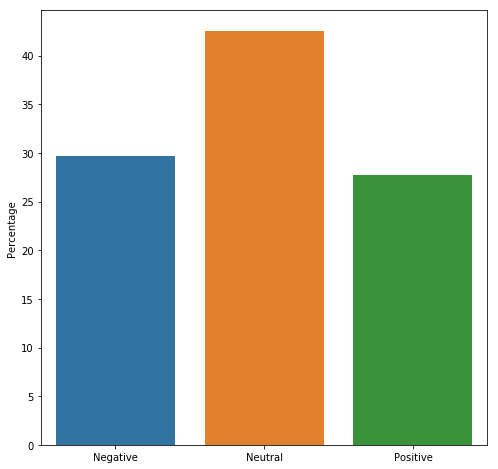

In [129]:
print(df1.label.value_counts())

print(df1.label.value_counts(normalize=True) * 100)

fig, ax = plt.subplots(figsize=(8, 8))

wcounts = df1.label.value_counts(normalize=True) * 100

sns.barplot(x=wcounts.index, y=wcounts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

Using wordclouds we will analyze the most frequent words in positive and negative news headlines.

First we will break the headlines into tokens.Tokenization is the process of breaking a stream of text up into meaningful elements called tokens. You can tokenize a paragraph into sentences, a sentence into words and so on. There's quite a few tokenizers, and you can view them all here: http://www.nltk.org/api/nltk.tokenize.html. Then stopwords are filtered out from the tokens.
words like ’the, ’is’, ’and’, ’what’, etc. that are somewhat irrelevant to text sentiment and don't provide any valuable information. These are called stopwords. We have used English stopword list that contains most of the common filler words that just add to our data size for no additional info.

We grab all of the positive label headlines from our dataframe, convert into tokens and create wordcloud to print most common words in the positive headlines. Some words used are tesla, musk , company which are really neutral words, a further enhancemeent can be to filter words after applying Vader sentiment on word-tokens. 

We refered to this for creating word-clouds: https://www.kaggle.com/adiljadoon/word-cloud-with-python


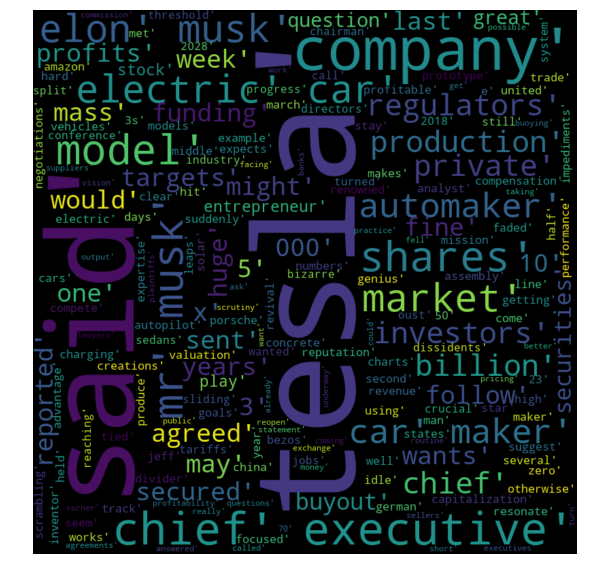

In [130]:
#Wordcloud
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk

stop_words = stopwords.words('english')
tokenizer = RegexpTokenizer(r'\w+')

#print(stop_words[:10])

def process_text(headlines):
    tokens = []
    for line in headlines:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    
    return tokens

pos_lines = list(df1[df1.label == 1].headline)
pos_tokens = process_text(pos_lines)

# Create the wordcloud object of words in positive headlines
wordcloud = WordCloud(width=800, height=800, margin=0).generate(str(pos_tokens))

#Show wordcloud image
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

The wordcloud image is generated for negative news headlines

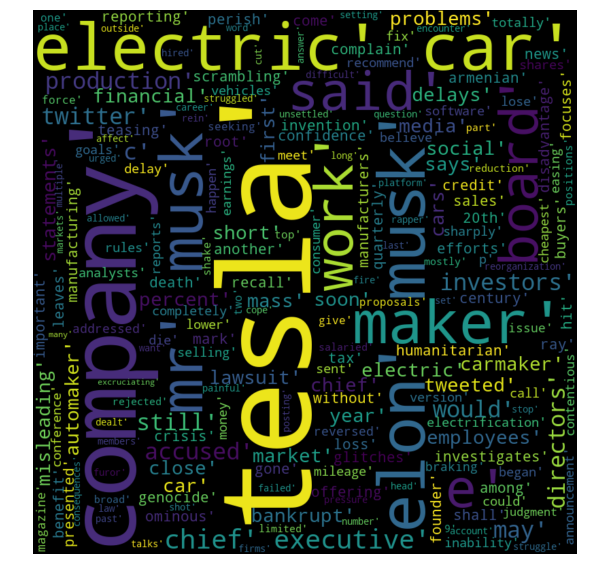

In [131]:
#Analysis for negative headlines. get tokens from negative headlines
neg_lines = list(df1[df1.label == -1].headline)
neg_tokens = process_text(neg_lines)

# Create the wordcloud object of words in negative headlines
wordcloud = WordCloud(width=800, height=800, margin=0).generate(str(neg_tokens))

#Show wordcloud image
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Part 3: Company Stock Data collection

Using pandas datareader package, we collect stock data of Tesla with Yahoo Finance API and put in a dataframe.

The columns desciptions are:
Open is the price of the stock at the beginning of the trading day (it need not be the closing price of the previous trading day), high is the highest price of the stock on that trading day, low the lowest price of the stock on that trading day, and close the price of the stock at closing time. Volume indicates how many stocks were traded. Adjusted close is the closing price of the stock that adjusts the price of the stock for corporate actions. While stock prices are considered to be set mostly by traders, stock splits (when the company makes each extant stock worth two and halves the price) and dividends (payout of company profits per share) also affect the price of a stock and should be accounted for.


In [132]:
#Get Stock Data from Yahoo Finance using pandas datareader
from pandas_datareader import data

#Tesla Motors Ticker,
#Set different company ticker here.
Ticker = 'TSLA'

# We would like all available data from 12/01/2017 until 12/01/2018.
start_date = '2017-11-30'
end_date = '2018-12-02'

# User pandas_reader.data.DataReader to load the desired data
stock_data = data.DataReader(Ticker, 'yahoo', start_date, end_date)
stock_data.head()

High         Low        Open       Close   Volume  \
Date                                                                  
2017-11-30  310.700012  304.540009  308.559998  308.850006  4351600   
2017-12-01  310.320007  305.049988  305.440002  306.529999  4292900   
2017-12-04  308.269989  300.609985  306.500000  305.200012  5835100   
2017-12-05  308.000000  301.000000  302.000000  303.700012  4646500   
2017-12-06  313.390015  300.000000  300.100006  313.260010  7195300   

             Adj Close  
Date                    
2017-11-30  308.850006  
2017-12-01  306.529999  
2017-12-04  305.200012  
2017-12-05  303.700012  
2017-12-06  313.260010

Using describe() we see the stats of various columns at a glance- mean , std, min etc.

In [133]:
#Looking at the statistics of Stock Data
stock_data.describe()


High         Low        Open       Close        Volume  \
count  254.000000  254.000000  254.000000  254.000000  2.540000e+02   
mean   321.894488  309.412677  315.597087  315.869568  8.415470e+06   
std    27.493111   27.426517   27.202239   27.329990   4.976534e+06   
min    260.329987  244.589996  252.779999  250.559998  3.080700e+06   
25%    302.730011  289.344994  297.080002  295.585007  5.193525e+06   
50%    322.305008  310.470001  316.065002  316.554993  6.955350e+06   
75%    346.602509  333.127510  339.655006  338.834999  9.327275e+06   
max    387.459991  367.119995  369.089996  379.570007  3.364970e+07   

        Adj Close  
count  254.000000  
mean   315.869568  
std    27.329990   
min    250.559998  
25%    295.585007  
50%    316.554993  
75%    338.834999  
max    379.570007

We referred to this page for studying about how moving average is used for stock trading analysis:https://www.investopedia.com/articles/active-trading/052014/how-use-moving-average-buy-stocks.asp

Here stock data, simple 20day moving average (used by shortterm traders) and 100 day moving average(used by long term traders) is plotted. The simple moving average has a delay or lag. The Exponential moving average of 20 days is also plotted which has less lag as it has more weight to current price. 

A strategy is to apply two moving averages to a chart: one longer and one shorter. When the shorter-term MA crosses above the longer-term MA, it's a buy signal, as it indicates that the trend is shifting up. This is known as a "golden cross."

For a year, Tesla's trend is overall same.

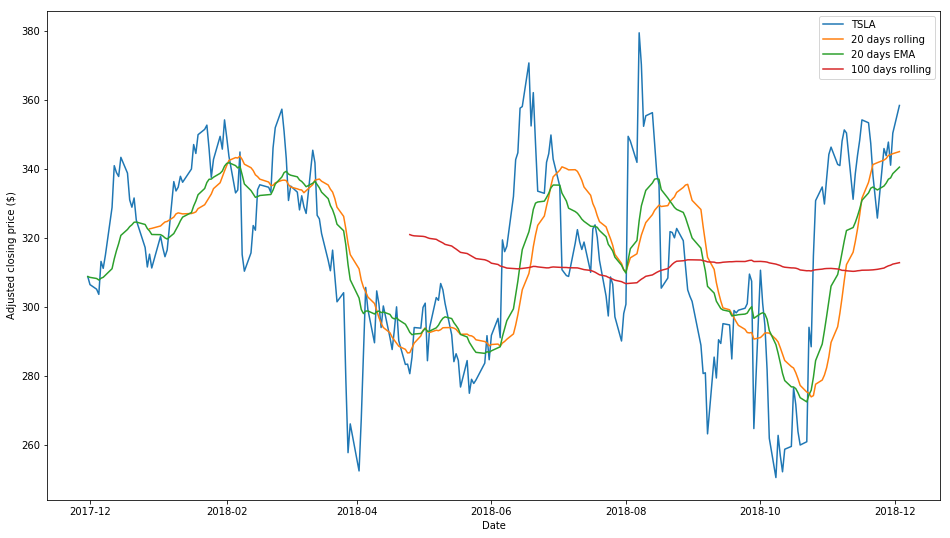

In [134]:
#Plotting Stock Data

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(stock_data.index, stock_data['Adj Close'], label='TSLA')

# Calculate the 20(SMA) and 20(EMA) and 100(SMA) days moving averages of the closing prices
ax.plot(stock_data.index, stock_data['Adj Close'].rolling(window=20).mean(), label='20 days rolling')
ax.plot(stock_data.index, stock_data['Adj Close'].ewm(span=20, adjust=False).mean(), label='20 days EMA')
ax.plot(stock_data.index, stock_data['Adj Close'].rolling(window=100).mean(), label='100 days rolling')

ax.set_xlabel('Date')
ax.set_ylabel('Adjusted closing price ($)')
ax.legend()

We plot volume of shares traded. Max is traded August-October frame

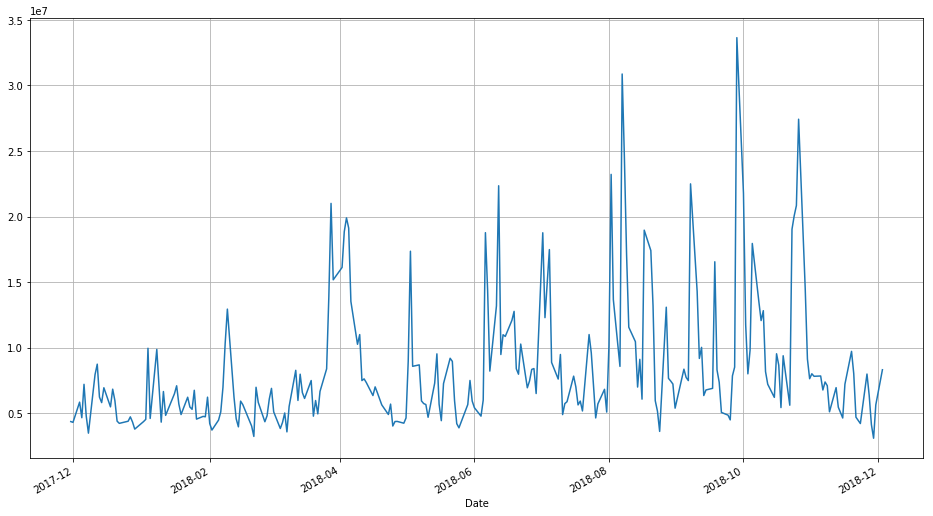

In [135]:
#Plotting Volume of Stocks
stock_data.Volume.plot(grid=True, figsize=(16,9))

Using Plotly interactive offline graphs we plot the candlestick plot of stock data. 

In [136]:
#Plotting interactive candlestick plot
import plotly.offline as py_offline
import plotly.graph_objs as go
py_offline.init_notebook_mode()

tsla_candle = go.Candlestick(x=stock_data.index,open=stock_data.Open,high=stock_data.High,low=stock_data.Low,close=stock_data.Close)
data = [tsla_candle]

py_offline.iplot(data, filename='Candle Stick')

The date for most negative news is April-2nd when Musk tweeted about bankrupcy. This is also when the stock price is lowest last year.

In [137]:
#Finding most negative news headline -- Musk tweets it has gone completely bankrupt on April 2nd
df1[df1['compound'] ==df1['compound'].min()]

compound  \
15 -0.8629     

                                                                                                                                    headline  \
15  After teasing “important news” to come, he tweeted: “Tesla has gone completely and totally bankrupt. So bankrupt, you can’t believe it.”   

      neg    neu  pos                date  label  
15  0.348  0.652  0.0 2018-04-02 00:18:52 -1

The most positive news is misleading. The stocks slid after Tesla's bizzare conference call

In [138]:
#Finding most positive news headline (The post conference news is actually negative and caused shares to slide)
#The tweet for going private led to highest increase in stock price around that time
df1[df1['compound'] ==df1['compound'].max()]

compound  \
25  0.7184     
91  0.7184     

                                                                                                                                                                                headline  \
25  The United States has an expertise advantage in trade negotiations with China; solar tariffs are scrambling the industry; and Tesla’s “bizarre” conference call sent shares sliding.   
91  The improvement is welcome news for a company that has been rocked by upheaval since Elon Musk, its chief executive, unveiled an abortive buyout plan.                                 

    neg    neu    pos                date  label  
25  0.0  0.767  0.233 2018-05-03 11:24:39  1      
91  0.0  0.786  0.214 2018-10-02 13:23:45  1

News articles around when the stock price is highest which is August 8,2018. This is when Musk tweeted that he will make company a private company.

In [139]:
#Around 2018-08-08 (highest stock price) news articles are:
df1[(df1['date']>pd.to_datetime('2018-08-07')) & (df1['date']<pd.to_datetime('2018-08-09')) ]

compound  \
41  0.1280     
42  0.0000     
43  0.0000     
44  0.0000     
45  0.5106     
46  0.4902     
47  0.2960     
48  0.0000     
49  0.0000     

                                                                                                                                                        headline  \
41  Tesla’s chief executive suggested that being a public company, beholden to shareholders, created perverse incentives for short-sellers.                        
42  Here’s what you need to know at the end of the day.                                                                                                            
43  Here’s what you need to know to start your day.                                                                                                                
44  Here’s what you need to know to start your day.                                                                                                                
45  There are some huge questions facing Elon Musk’s vision of taking his automaker off the public market.                                                         
46  Investors should ask: Where is the money coming from and would Tesla really be better off as a private company?                                                
47  Mr. Musk’s statement that he had “funding secured” for a possible $70 billion buyout could get scrutiny from securities regulators and plaintiffs’ lawyers.    
48  Here’s what you need to know to start your day.                                                                                                                
49  Banks including Citigroup and Goldman Sachs are looking at ways to structure transactions for Tesla that would remove the automaker from the public markets.   

      neg    neu    pos                date  label  
41  0.139  0.647  0.214 2018-08-07 18:45:37  0      
42  0.000  1.000  0.000 2018-08-07 22:01:14  0      
43  0.000  1.000  0.000 2018-08-08 04:18:08  0      
44  0.000  1.000  0.000 2018-08-08 09:23:27  0      
45  0.000  0.777  0.223 2018-08-08 10:26:53  1      
46  0.000  0.850  0.150 2018-08-08 12:52:45  1      
47  0.000  0.905  0.095 2018-08-08 14:24:35  1      
48  0.000  1.000  0.000 2018-08-08 20:21:01  0      
49  0.000  1.000  0.000 2018-08-08 23:17:42  0

News articles around 2nd highest stock price peak when Tesla fired 9% of factory employees. In around July timeframe they reached their Model S goal.

In [140]:
#Around 2018-06-18 (2nd high stock price peak) news articles are:
df1[(df1['date']>pd.to_datetime('2018-06-10')) & (df1['date']<pd.to_datetime('2018-06-30')) ]

compound  \
33 -0.2263     
34 -0.1761     
35  0.0000     

                                                                                                                                                 headline  \
33  The automaker said the 9 percent reduction, mostly limited to salaried employees, was part of a broad reorganization and would not affect production.   
34  Layoffs at the carmaker suggest that the company is taking a more cautious approach to its business. But that raises a whole new set of questions.      
35  In an email to workers, he said the operation was “quite extensive and damaging” at a time when the automaker was scrambling to ramp up production.     

      neg    neu  pos                date  label  
33  0.087  0.913  0.0 2018-06-12 19:13:52 -1      
34  0.069  0.931  0.0 2018-06-13 10:28:19  0      
35  0.000  1.000  0.0 2018-06-19 16:09:12  0

Adding markers around stockprice peaks and troughs and above news around these are analyzed.

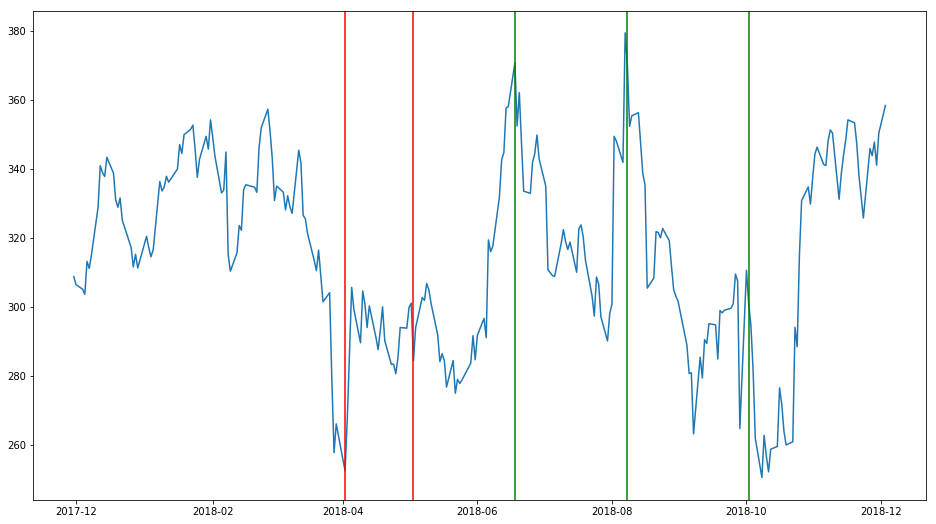

In [141]:
#Plotting Stock Data
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(stock_data.index, stock_data['Adj Close'], label='TSLA')

plt.axvline(pd.to_datetime('2018-04-02'), color='r')
plt.axvline(pd.to_datetime('2018-05-03'), color='r')
plt.axvline(pd.to_datetime('2018-06-18'), color='g')
plt.axvline(pd.to_datetime('2018-08-08'), color='g')
plt.axvline(pd.to_datetime('2018-10-02'), color='g')

We calculate pearsons correlation coefficient between news sentiment compound score and the next days stock price change. We filter out the neutral news. We normalized the stock price values by dividing by mean stock price over the year. Then we plot both the vectors as well.

In [142]:
changeStockData = []
sentimentData = []
stock_data1 = stock_data.reset_index()

df1['date1'] = df1.date.dt.date

for i,r in df1.iterrows():
    for idx,row in stock_data1.iterrows():
        if (str(r.date1) in str(row.Date)) & (r['label'] !=0):
            changeStockData.append((stock_data.iloc[idx+1]['Adj Close']-stock_data.iloc[idx]['Adj Close'])/stock_data['Adj Close'].mean())
            sentimentData.append(r['compound'])

print("StockDataChange:\n", changeStockData, len(changeStockData))

print("SentimentData:\n", sentimentData, len(sentimentData))            


StockDataChange:
 [-0.010384029091180701, -0.005476978992639891, -0.02184444024867058, -0.02184444024867058, -0.09424772774713244, -0.09424772774713244, 0.01297996390310614, -0.043214068571582574, 0.047646258437118304, 0.05945491653456074, 0.017918800169837934, -0.05286986592191367, 0.03051887588654001, 0.03051887588654001, 0.012853398917300106, -0.02212935638847363, 0.08981553788159671, 0.08981553788159671, 0.006363416965747036, -0.07664562988528854, -0.01826709541703698, 0.15417760112919124, -0.05663725146124229, -0.05663725146124229, -0.05663725146124229, 0.009624156103879589, -0.027764589920617554, -0.010257367490881686, -0.010257367490881686, -0.010257367490881686, -0.010257367490881686, 0.009307647024871524, 0.009307647024871524, 0.009307647024871524, 0.009307647024871524, -0.0008230588657111473, -0.011238874125082829, -0.011238874125082829, 0.0024377768869143874, -0.13534067343254816, 0.1454081934447208, 0.1454081934447208, -0.030645634101332007, -0.030645634101332007, -0.019691

In [143]:
from scipy import stats
import numpy as np
stats.pearsonr(np.array(sentimentData),np.array(changeStockData))

(-0.1263966632997334, 0.3868114957559605)

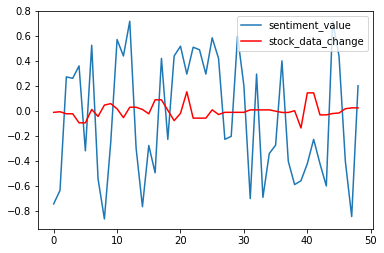

In [144]:
plt.plot(sentimentData, label='sentiment_value')
plt.plot(changeStockData, c='r', label='stock_data_change')
plt.legend()

# Part 4: Analysis using Pearsons correlation coefficient.

Contrary to expectation the correlation coefficient is slightly negative. However the values are so low it is not decisive. 
Some of the things that we can do in the future to better understand this are-

1)Build more sentiment analysis lexicon for finance news. Here some neutral and positive news are misleading.
2)Coefficent is calculated on next days price change, however this can be next 5 or 10 days average change.
3)Stock data is not available on the weekend and some articles got filtered out as next day was weekend, hence a more robust algorithm can be developed.

